# Data Story: DreamCatcher Cache + Preprocessing

This notebook explains the dataset subset and preprocessing artifacts used by the benchmark.

**Run order:**
1. `python3 scripts/preprocess.py`
2. Open and run this notebook

**Dependencies:** only local cache artifacts under `results/cache/spectrograms/`.


In [27]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(42)

CWD = Path.cwd()
if (CWD / 'results').exists():
    ROOT = CWD
elif (CWD.parent / 'results').exists():
    ROOT = CWD.parent
else:
    raise FileNotFoundError('Could not locate repo root containing results/.')
CACHE_DIR = ROOT / 'results' / 'cache' / 'spectrograms'
SPLITS = ['train', 'validation', 'test']
LABELS = ['quiet', 'breathe', 'snore']
COLORS = ['#2ecc71', '#3498db', '#e74c3c']

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True


## A) Dataset Scope and Reproducibility Context

We use the 3-class subset: `quiet`, `breathe`, `snore`.
The cells below verify cached split metadata (`n_samples`, `n_mels`, `sample_rate`, `max_time`).


In [28]:
meta_rows = []
split_labels = {}

for split in SPLITS:
    p = CACHE_DIR / f'{split}.h5'
    if not p.exists():
        raise FileNotFoundError(f'Missing cache file: {p}')
    with h5py.File(p, 'r') as h5:
        labels = h5['labels'][:]
        split_labels[split] = labels
        meta_rows.append(
            {
                'split': split,
                'n_samples': int(h5.attrs['n_samples']),
                'n_mels': int(h5.attrs['n_mels']),
                'max_time': int(h5.attrs['max_time']),
                'sample_rate': int(h5.attrs['sample_rate']),
            }
        )

meta_df = pd.DataFrame(meta_rows)
display(meta_df)

unique_n_mels = sorted(meta_df['n_mels'].unique().tolist())
print('unique n_mels:', unique_n_mels)
assert unique_n_mels == [64], f'Expected n_mels=64, got {unique_n_mels}'


,split,n_samples,n_mels,max_time,sample_rate
0,train,250050,64,501,16000
1,validation,63056,64,501,16000
2,test,67256,64,501,16000


unique n_mels: [64]


## B) Split-wise Class Distribution


In [29]:
dist_rows = []
for split, labels in split_labels.items():
    total = len(labels)
    for class_id, class_name in enumerate(LABELS):
        count = int((labels == class_id).sum())
        dist_rows.append(
            {
                'split': split,
                'class_id': class_id,
                'class_name': class_name,
                'count': count,
                'pct': 100.0 * count / total,
            }
        )

dist_df = pd.DataFrame(dist_rows)
display(dist_df)


,split,class_id,class_name,count,pct
0,train,0,quiet,139006,55.591282
1,train,1,breathe,87710,35.076985
2,train,2,snore,23334,9.331734
3,validation,0,quiet,33453,53.052842
4,validation,1,breathe,22740,36.063182
5,validation,2,snore,6863,10.883976
6,test,0,quiet,36212,53.842036
7,test,1,breathe,24403,36.283752
8,test,2,snore,6641,9.874212


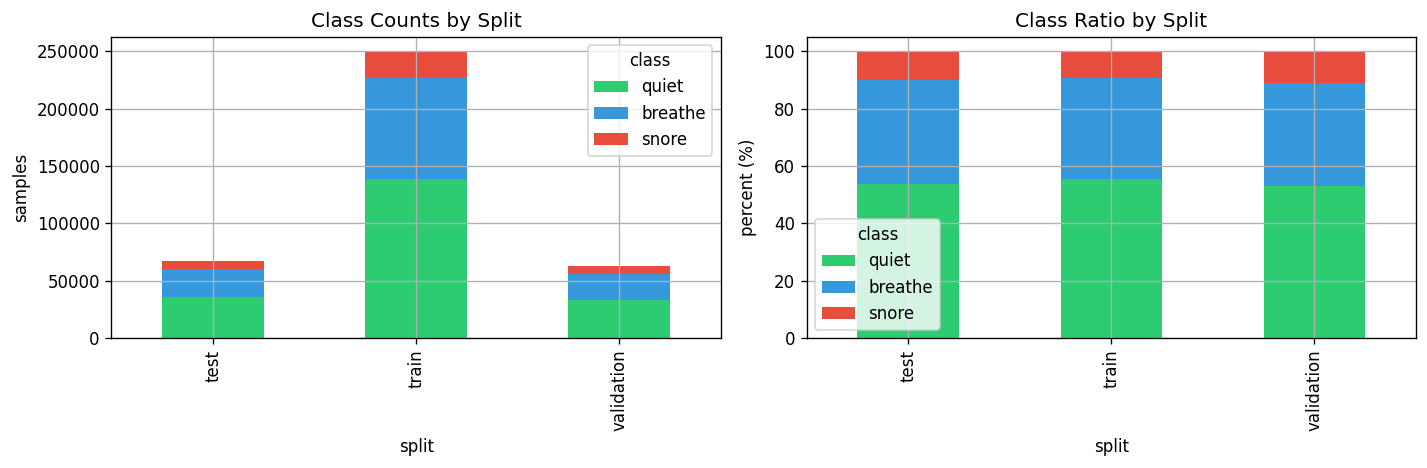

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Absolute counts
count_pivot = dist_df.pivot(index='split', columns='class_name', values='count')[LABELS]
count_pivot.plot(kind='bar', stacked=True, ax=axes[0], color=COLORS)
axes[0].set_title('Class Counts by Split')
axes[0].set_ylabel('samples')
axes[0].legend(title='class')

# Percentages
pct_pivot = dist_df.pivot(index='split', columns='class_name', values='pct')[LABELS]
pct_pivot.plot(kind='bar', stacked=True, ax=axes[1], color=COLORS)
axes[1].set_title('Class Ratio by Split')
axes[1].set_ylabel('percent (%)')
axes[1].legend(title='class')

plt.tight_layout()
plt.show()


## C) Sample Spectrograms by Class (Train Split)


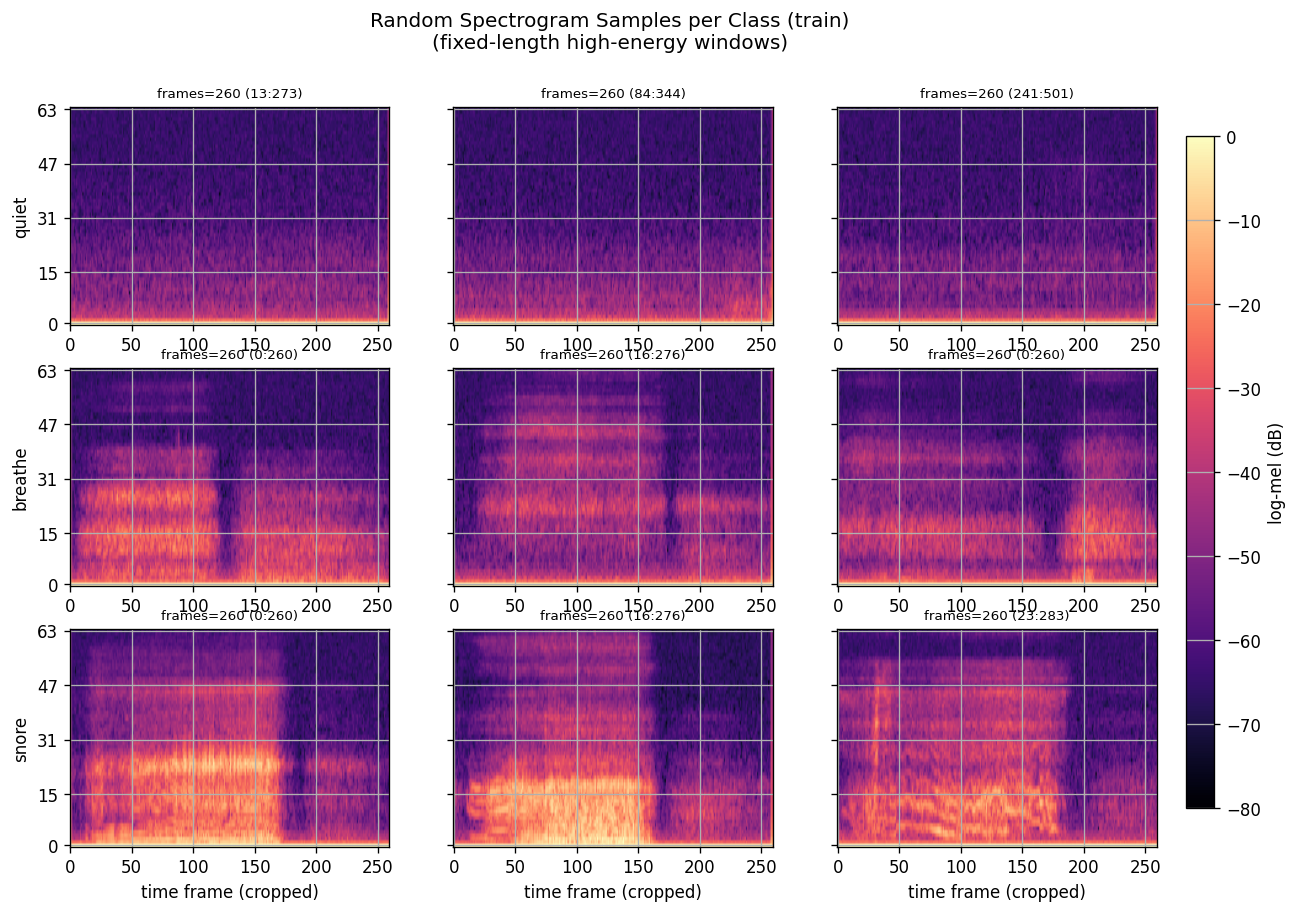

In [31]:
train_path = CACHE_DIR / 'train.h5'
rng = np.random.default_rng(42)

with h5py.File(train_path, 'r') as h5:
    train_specs = h5['spectrograms']
    train_labels = h5['labels'][:]
    n_mels = train_specs.shape[1]

    n_show = 3
    pool_per_class = 500
    window_len = 260  # fixed visualization window (for consistency/readability)

    per_class_idx = {}
    per_class_span = {}

    for class_id in range(len(LABELS)):
        candidates = np.where(train_labels == class_id)[0]
        pool = rng.choice(candidates, size=min(pool_per_class, len(candidates)), replace=False)

        scored = []
        for idx in pool:
            spec = train_specs[int(idx)]
            frame_energy = spec.mean(axis=0)

            if spec.shape[1] <= window_len:
                start, end = 0, int(spec.shape[1])
                best_score = float(frame_energy.mean())
            else:
                cs = np.cumsum(np.r_[0.0, frame_energy])
                means = (cs[window_len:] - cs[:-window_len]) / window_len
                best_start = int(np.argmax(means))
                start, end = best_start, best_start + window_len
                best_score = float(means[best_start])

            scored.append((best_score, int(idx), start, end))

        top = sorted(scored, reverse=True)[:n_show]
        per_class_idx[class_id] = [idx for _, idx, _, _ in top]
        per_class_span[class_id] = [(start, end) for _, _, start, end in top]

    fig, axes = plt.subplots(len(LABELS), n_show, figsize=(12, 8), sharey=True)
    mel_ticks = np.linspace(0, n_mels - 1, num=5, dtype=int)
    im = None

    for row, class_id in enumerate(range(len(LABELS))):
        for col, idx in enumerate(per_class_idx[class_id]):
            spec = train_specs[int(idx)]
            start, end = per_class_span[class_id][col]
            spec_crop = spec[:, start:end]

            ax = axes[row, col]
            im = ax.imshow(spec_crop, origin='lower', aspect='auto', cmap='magma', vmin=-80, vmax=0)

            if col == 0:
                ax.set_ylabel(LABELS[class_id])
            if row == len(LABELS) - 1:
                ax.set_xlabel('time frame (cropped)')

            ax.set_title(f'frames={end-start} ({start}:{end})', fontsize=8)
            ax.set_yticks(mel_ticks)
            ax.set_yticklabels([str(int(t)) for t in mel_ticks])

    fig.suptitle(
        'Random Spectrogram Samples per Class (train)\n'
        '(fixed-length high-energy windows)',
        y=0.98,
    )
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('log-mel (dB)')
    plt.show()


## D) Preprocessing Diagnostics

Checks:
- clip length / time-frame consistency
- dB quantiles
- finite values (`NaN`/`inf`) on random samples


In [32]:
diag_rows = []

for split in SPLITS:
    p = CACHE_DIR / f'{split}.h5'
    with h5py.File(p, 'r') as h5:
        specs = h5['spectrograms']
        n = specs.shape[0]
        sample_n = min(2000, n)
        idx = np.sort(np.random.choice(n, size=sample_n, replace=False))
        sample = specs[idx]

        finite_ratio = np.isfinite(sample).mean()
        diag_rows.append(
            {
                'split': split,
                'shape': tuple(specs.shape),
                'finite_ratio': float(finite_ratio),
                'db_min': float(np.min(sample)),
                'db_q01': float(np.quantile(sample, 0.01)),
                'db_q50': float(np.quantile(sample, 0.50)),
                'db_q99': float(np.quantile(sample, 0.99)),
                'db_max': float(np.max(sample)),
            }
        )

diag_df = pd.DataFrame(diag_rows)
display(diag_df)

assert (diag_df['finite_ratio'] == 1.0).all(), 'Found non-finite values in sampled cache tensors.'


,split,shape,finite_ratio,db_min,db_q01,db_q50,db_q99,db_max
0,train,"(250050, 64, 501)",1.0,-80.0,-80.0,-78.553299,-24.908724,0.000002
1,validation,"(63056, 64, 501)",1.0,-80.0,-80.0,-78.436615,-24.757965,0.000002
2,test,"(67256, 64, 501)",1.0,-80.0,-80.0,-78.512665,-24.882765,0.000002


## E) Compact Class-Level Acoustic Summaries

- Average spectrogram per class (shared color scale)
- Temporal energy profile with variability band


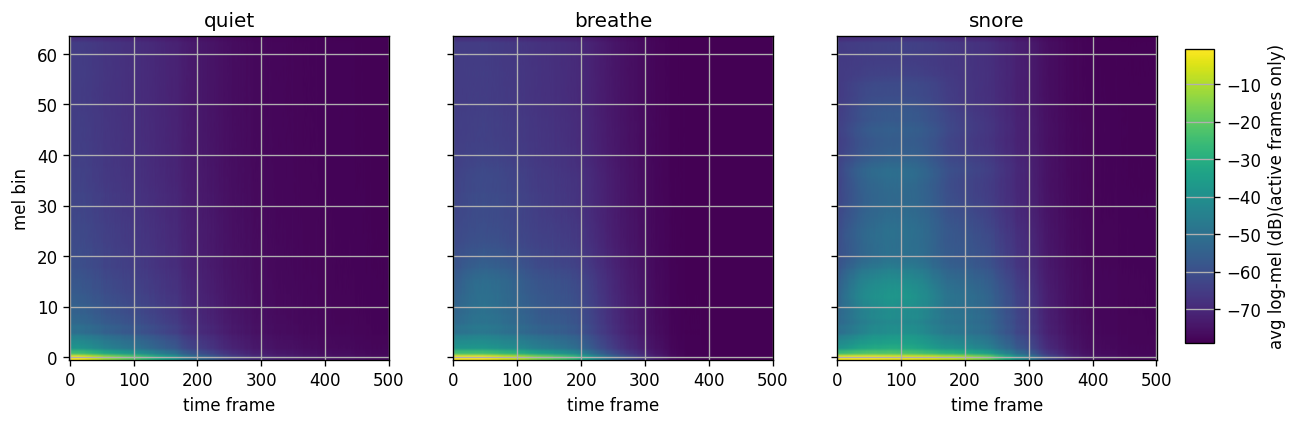

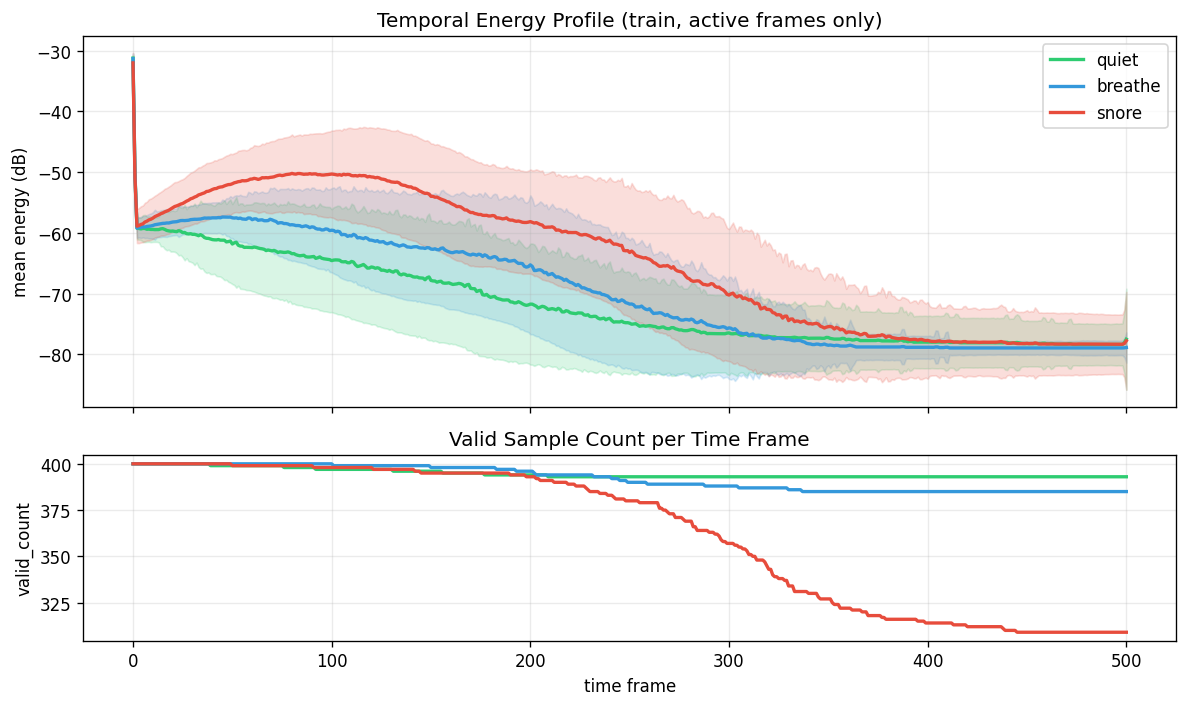

In [34]:
n_per_class = 400
avg_specs_active = {}
temporal_mean_active = {}
temporal_std_active = {}
temporal_valid_count = {}

with h5py.File(CACHE_DIR / 'train.h5', 'r') as h5:
    specs = h5['spectrograms']
    labels = h5['labels'][:]

    # Estimate padding floor (typically around -80 dB) from a lightweight probe.
    probe_n = min(128, specs.shape[0])
    probe_idx = np.linspace(0, specs.shape[0] - 1, num=probe_n, dtype=int)
    pad_db = min(float(specs[int(i)].min()) for i in probe_idx)
    active_threshold = pad_db + 1e-6

    for class_id in range(len(LABELS)):
        idx = np.where(labels == class_id)[0][:n_per_class]
        class_specs = np.asarray(specs[idx], dtype=np.float32)  # [N, mel, time]

        # A time frame is valid if any mel bin is above the padding floor.
        active_mask = np.any(class_specs > active_threshold, axis=1)  # [N, time]
        spec_mask = active_mask[:, None, :]  # [N, 1, time]

        class_specs_masked = np.where(spec_mask, class_specs, np.nan)
        avg_specs_active[class_id] = np.nanmean(class_specs_masked, axis=0)

        temporal_profiles = class_specs.mean(axis=1)  # [N, time]
        temporal_profiles = np.where(active_mask, temporal_profiles, np.nan)
        temporal_mean_active[class_id] = np.nanmean(temporal_profiles, axis=0)
        temporal_std_active[class_id] = np.nanstd(temporal_profiles, axis=0)
        temporal_valid_count[class_id] = active_mask.sum(axis=0)

global_min = min(np.nanmin(arr) for arr in avg_specs_active.values())
global_max = max(np.nanmax(arr) for arr in avg_specs_active.values())

fig, axes = plt.subplots(1, len(LABELS), figsize=(12, 3.5), sharex=True, sharey=True)
cmap = plt.get_cmap('viridis').copy()
cmap.set_bad(color='#0f0f0f')
for i, class_id in enumerate(range(len(LABELS))):
    ax = axes[i]
    im = ax.imshow(
        avg_specs_active[class_id],
        origin='lower',
        aspect='auto',
        cmap=cmap,
        vmin=global_min,
        vmax=global_max,
    )
    ax.set_title(f"{LABELS[class_id]}")
    ax.set_xlabel('time frame')
    if i == 0:
        ax.set_ylabel('mel bin')

fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('avg log-mel (dB)(active frames only)')
plt.show()

t = np.arange(next(iter(temporal_mean_active.values())).shape[0])
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(10, 6),
    sharex=True,
    gridspec_kw={'height_ratios': [2, 1]},
)

for class_id, color in enumerate(COLORS):
    m = temporal_mean_active[class_id]
    s = temporal_std_active[class_id]
    valid = np.isfinite(m)

    ax1.plot(t[valid], m[valid], color=color, label=LABELS[class_id], lw=2)
    ax1.fill_between(t[valid], (m - s)[valid], (m + s)[valid], color=color, alpha=0.18)

    vc = temporal_valid_count[class_id]
    ax2.plot(t, vc, color=color, lw=2, label=LABELS[class_id])

ax1.set_title('Temporal Energy Profile (train, active frames only)')
ax1.set_ylabel('mean energy (dB)')
ax1.legend()
ax1.grid(True, alpha=0.25)

ax2.set_title('Valid Sample Count per Time Frame')
ax2.set_xlabel('time frame')
ax2.set_ylabel('valid_count')
ax2.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()



## Notes

- This notebook is intentionally compact and preprocessing-focused.
- Model comparison and KD interpretation are in `notebooks/results_analysis.ipynb`.
